In [46]:

import geopandas as gpd
edges_df = gpd.read_file('edges.gpkg')
nodes_df = gpd.read_file('nodes.gpkg')

print(nodes_df.head())
print(edges_df.head())

   type  room_num  floor  connector_id  name                  geometry
0     1       NaN      1           1.0  None  POINT (147.923 -669.744)
1     2    1312.0      1           NaN  None  POINT (183.355 -537.374)
2     2    1506.0      1           NaN  None  POINT (364.692 -571.743)
3     2    1408.0      1           NaN  None  POINT (422.241 -590.314)
4     2    1405.0      1           NaN  None  POINT (437.946 -586.467)
   from_id  to_id  weight  floor  \
0       20     38      34      1   
1       38      1      64      1   
2        1     39     136      1   
3        2     39      30      1   
4        2     40      43      1   

                                          geometry  
0   LINESTRING (180.93 -740.386, 149.393 -738.557)  
1  LINESTRING (149.393 -738.557, 147.923 -669.744)  
2  LINESTRING (147.923 -669.744, 157.896 -523.781)  
3  LINESTRING (183.355 -537.374, 157.896 -523.781)  
4  LINESTRING (183.355 -537.374, 221.196 -521.751)  


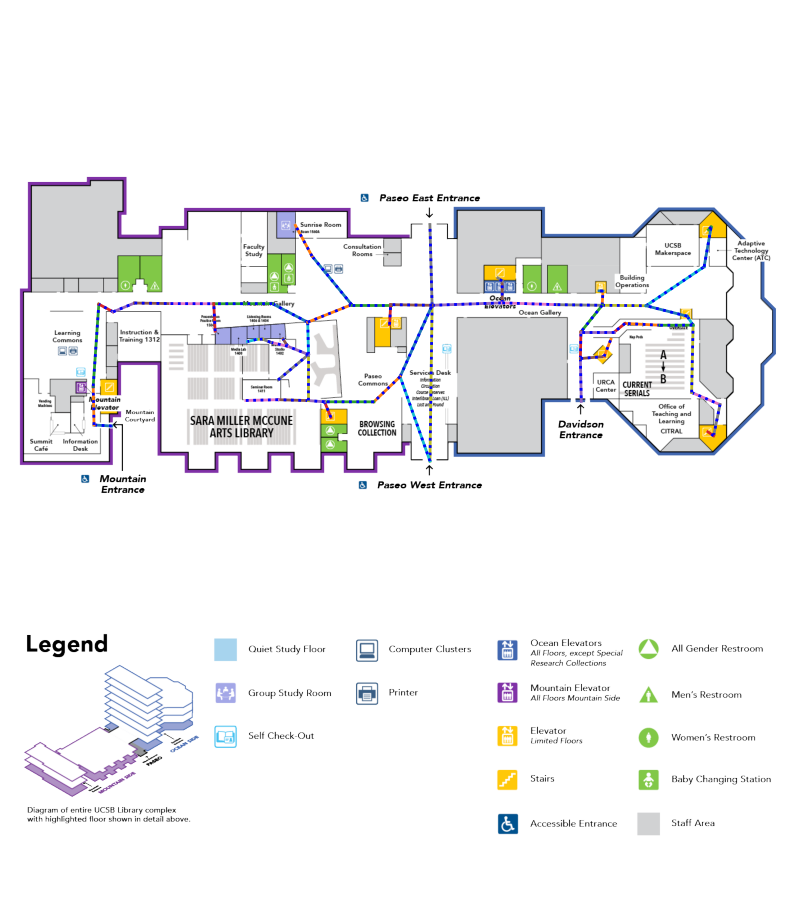

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# edges_df columns: from_id, to_id, weight, floor, geometry (shapely LineString)
# Filter to floor 1 if you want:
floor = 1


# Load a sample GeoDataFrame

df = edges_df[edges_df["floor"] == floor]

# Load the floor plan image
img = mpimg.imread("1.png")

# QGIS raster extent you reported:
xmin, ymin, xmax, ymax = 0.0, -1560.0, 1369.0, 0.0

fig, ax = plt.subplots()

# Draw image in the same coordinate system as your vectors
ax.imshow(img, extent=(xmin, xmax, ymin, ymax), origin="upper")

# Overlay graph edges
for line in df["geometry"]:
    xs, ys = line.xy
    ax.plot(xs, ys, linewidth=2)
    # same color, dotted line for all edges
    ax.plot(xs, ys, linewidth=2, color='blue', linestyle='dotted')
    

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#set image size to match floor plan aspect ratio
plot_width = 10  # inches
plot_height = plot_width * (ymax - ymin) / (xmax - xmin)
fig.set_size_inches(plot_width, plot_height)

ax.set_aspect("equal")   # important: don’t stretch geometry
ax.axis("off")
plt.show()


In [11]:
print(nodes_df.head())
print(edges_df.head())

   type  room_num  floor  connector_id  name                  geometry
0     1       NaN      1           1.0  None  POINT (147.923 -669.744)
1     2    1312.0      1           NaN  None  POINT (183.355 -537.374)
2     2    1506.0      1           NaN  None  POINT (364.692 -571.743)
3     2    1408.0      1           NaN  None  POINT (422.241 -590.314)
4     2    1405.0      1           NaN  None  POINT (437.946 -586.467)
   from_id  to_id  weight  floor  \
0       20     38      34      1   
1       38      1      64      1   
2        1     39     136      1   
3        2     39      30      1   
4        2     40      43      1   

                                          geometry  
0   LINESTRING (180.93 -740.386, 149.393 -738.557)  
1  LINESTRING (149.393 -738.557, 147.923 -669.744)  
2  LINESTRING (147.923 -669.744, 157.896 -523.781)  
3  LINESTRING (183.355 -537.374, 157.896 -523.781)  
4  LINESTRING (183.355 -537.374, 221.196 -521.751)  


In [48]:
import networkx as nx

def build_graph(nodes_df, edges_df, node_id_col="fid"):
    """
    Build a weighted undirected graph from nodes/edges GeoDataFrames.

    Nodes store:
      - x, y (image/world coords used in QGIS)
      - floor, type, room_num, connector_id, name

    Edges store:
      - weight, floor
    """
    G = nx.Graph()

    # Decide node id column
    if node_id_col in nodes_df.columns:
        get_node_id = lambda row: int(row[node_id_col])
    else:
        # Fallback: index. This only works if edges from_id/to_id match this indexing.
        get_node_id = lambda row: int(row.name)

    # ---- Add nodes with attributes ----
    for _, row in nodes_df.iterrows():
        nid = get_node_id(row)
        pt = row["geometry"]  # shapely Point

        G.add_node(
            nid,
            x=float(pt.x)-1,
            y=float(pt.y)-1,
            floor=int(row["floor"]) if row.get("floor") is not None else None,
            type=int(row["type"]) if row.get("type") is not None else None,
            room_num=None if row.get("room_num") is None else row.get("room_num"),
            connector_id=None if row.get("connector_id") is None else row.get("connector_id"),
            name=None if row.get("name") is None else row.get("name"),
        )

    # ---- Add edges with weight ----
    for _, row in edges_df.iterrows():
        u = int(row["from_id"]) -1
        v = int(row["to_id"]) -1
        w = float(row["weight"]) if row["weight"] is not None else None

        # Only add edges where both endpoints exist
        if u not in G.nodes or v not in G.nodes:
            continue

        G.add_edge(
            u, v,
            weight=w,
            floor=int(row["floor"]) if row.get("floor") is not None else None,
            geometry=row.get("geometry", None)  # keep shapely LineString if present
        )

    return G

# Usage:
G = build_graph(nodes_df, edges_df, node_id_col="fid")  # if you have nodes_df["fid"]



Starting from entrance  paseo west to room 2308.0
Path from node 18 to node 58: [18, 53, 52, 50, 14, 81, 105, 102, 95, 93, 92, 91, 90, 89, 86, 85, 58]


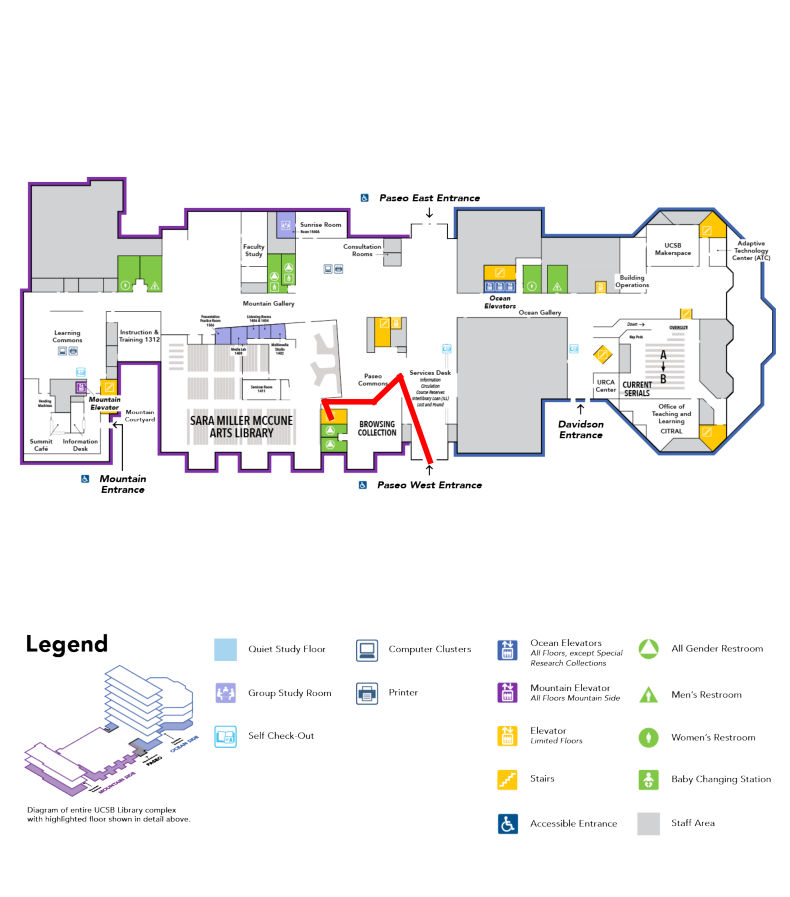

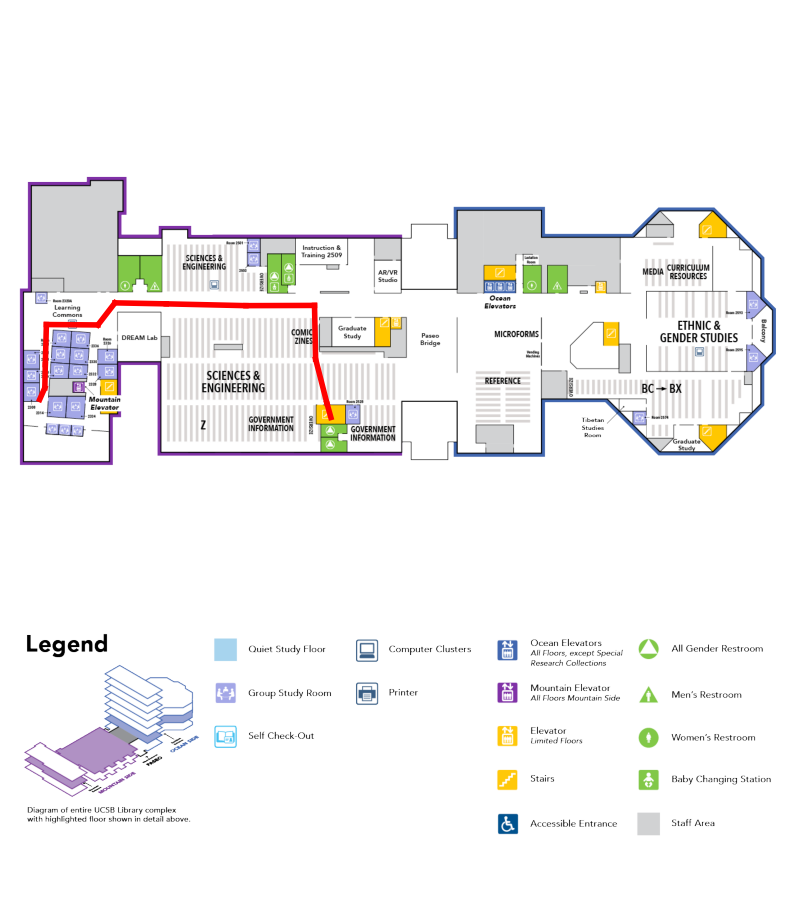

In [52]:
#start from any node which is type 3, and traverse to a random room on floor 2.
#store the path then visualize it on two floor plans.
import random
from random import choice



# Find a node of type 3
type_3_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type") == 3]
if not type_3_nodes:
    raise ValueError("No nodes of type 3 found")

# Select a random starting node
start_node = random.choice(type_3_nodes)



# Find all nodes on floor 2 that are rooms (assuming room nodes have a specific type or attribute)
room_nodes = [n for n, attr in G.nodes(data=True) if attr.get("floor") == 2 and attr.get("type") == 2]  # Adjust condition as needed
if not room_nodes:
    raise ValueError("No room nodes found on floor 2")

# Select a random destination room
end_node = random.choice(room_nodes)

# Find the shortest path between start and end nodes
path = nx.shortest_path(G, start_node, end_node, weight="weight")

print("Starting from entrance ", G.nodes[start_node].get("name"), "to room", G.nodes[end_node].get("room_num"))
print(f"Path from node {start_node} to node {end_node}: {path}")

# show example
plot_path_on_floor(G, path, floor=1, floor_image_file="1.png", xmin=0.0, ymin=-1560.0, xmax=1369.0, ymax=0.0)
plot_path_on_floor(G, path, floor=2, floor_image_file="2.png", xmin=0.0, ymin=-1560.0, xmax=1369.0, ymax=0.0)

In [37]:
#show the path on the floor plans for floor 1 and floor 2
def plot_path_on_floor(G, path, floor, floor_image_file, xmin, ymin, xmax, ymax):
    fig, ax = plt.subplots()

    # Load and draw floor plan image
    img = mpimg.imread(floor_image_file)
    ax.imshow(img, extent=(xmin, xmax, ymin, ymax), origin="upper")

    # Extract edges in the path that are on the specified floor
    path_edges = []
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        if G.has_edge(u, v) and G[u][v].get("floor") == floor:
            path_edges.append((u, v))

    # Overlay path edges
    for u, v in path_edges:
        line = G[u][v].get("geometry")
        if line:
            xs, ys = line.xy
            ax.plot(xs, ys, linewidth=4, color='red')  # Highlighted path

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    #set image size to match floor plan aspect ratio
    plot_width = 10  # inches
    plot_height = plot_width * (ymax - ymin) / (xmax - xmin)
    fig.set_size_inches(plot_width, plot_height)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.show()
    
    

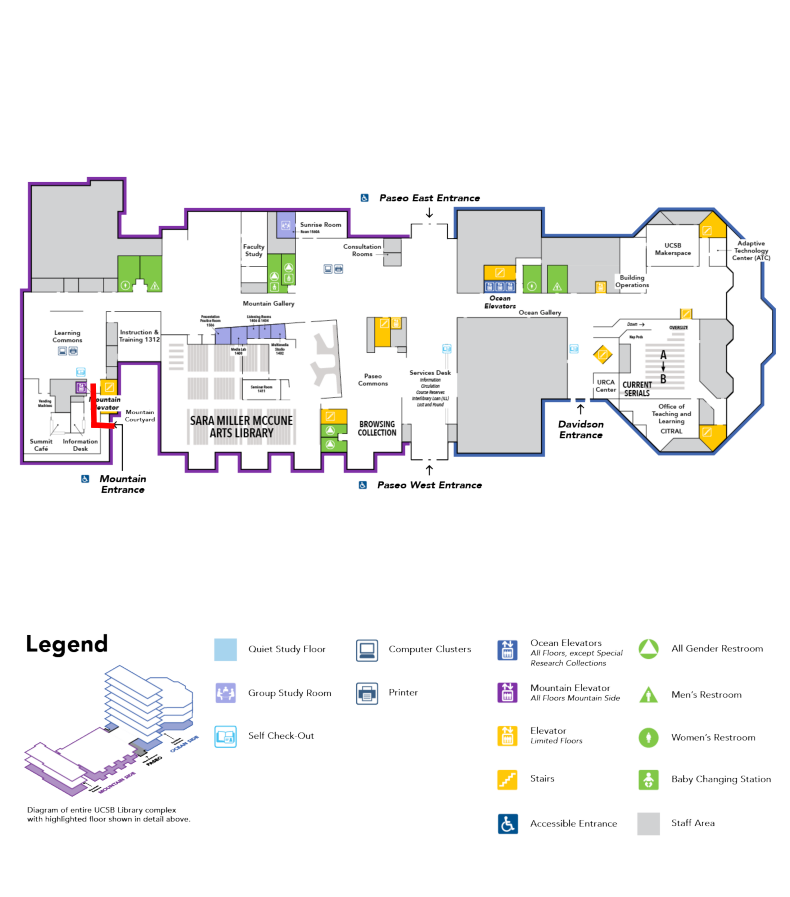

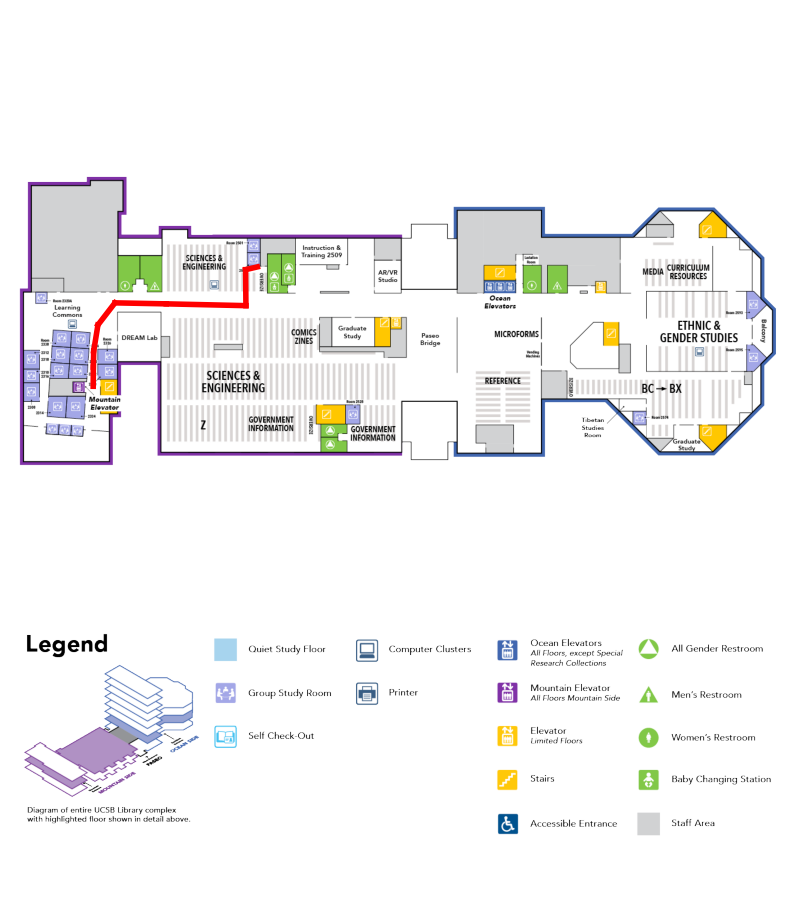